In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
from itertools import cycle
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba
import scienceplots

In [2]:
class LatticeBase(abc.ABC):
    def __init__(self, size):
        self.size = size
        self.lattice = None

    @abc.abstractmethod
    def initialize(self):
        pass

    @abc.abstractmethod
    def get_random_site(self):
        pass

    @abc.abstractmethod
    def get_neighbors(self, site):
        pass

    @abc.abstractmethod
    def get_occupancy(self):
        pass

    @abc.abstractmethod
    def plot(self, title="Estado de la red", figsize=(6,6)):
        pass


In [3]:
class SquareLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_all_sites(self):
        return [(i, j) for i in range(self.lattice.shape[0]) for j in range(self.lattice.shape[1])]


    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site
        return [(ni, nj) for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
                if 0 <= ni < self.size and 0 <= nj < self.size]

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red cuadrada", figsize=(6,6)):
        fig, ax = plt.subplots(figsize=figsize)
        for i in range(self.size):
            for j in range(self.size):
                color = "black" if self.lattice[i, j] == 1 else "white"
                rect = patches.Rectangle((j, self.size - i - 1), 1, 1, edgecolor='gray', facecolor=color)
                ax.add_patch(rect)
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_title(title)
        ax.axis('off')
        plt.show()


In [9]:
import matplotlib.patches as patches
import numpy as np

class HexagonalLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_all_sites(self):
        return [(i, j) for i in range(self.lattice.shape[0]) for j in range(self.lattice.shape[1])]

    def get_neighbors(self, site):
        i, j = site

        # Definición de vecinos para layout even-r (fila par desplazada)
        if i % 2 == 0:  # Fila par
            deltas = [(-1, 0), (-1, -1),
                    (0, -1),  (0, +1),
                    (+1, 0), (+1, -1)]
        else:  # Fila impar
            deltas = [(-1, +1), (-1, 0),
                    (0, -1),  (0, +1),
                    (+1, +1), (+1, 0)]

        neighbors = [(i + di, j + dj) for di, dj in deltas
                    if 0 <= i + di < self.size and 0 <= j + dj < self.size]

        return neighbors

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red hexagonal", figsize=(6, 6)):
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches

        fig, ax = plt.subplots(figsize=figsize)

        dx = 3 ** 0.5  # horizontal spacing
        dy = 1.5       # vertical spacing
        radius = 0.5

        for i in range(self.size):
            for j in range(self.size):
                x = dx * j + (dx / 2 if i % 2 else 0)
                y = dy * i
                color = "black" if self.lattice[i, j] == 1 else "white"]

                hexagon = patches.RegularPolygon(
                    (x, y),
                    numVertices=6,
                    radius=radius,
                    orientation=np.radians(30),
                    edgecolor='gray',
                    facecolor=color,
                    linewidth=0.5
                )
                ax.add_patch(hexagon)

        ax.set_aspect('equal')
        ax.set_xlim(-1, dx * self.size + 1)
        ax.set_ylim(-1, dy * self.size + 1)
        ax.set_title(title)
        ax.axis('off')
        plt.tight_layout()
        plt.show()




SyntaxError: unmatched ']' (68260045.py, line 50)

In [10]:
size = 10
hex_lattice = HexagonalLattice(size=10)


# Graficar
hex_lattice.plot(title="Red hexagonal aleatoria")


TypeError: Can't instantiate abstract class HexagonalLattice with abstract method get_random_site

In [17]:
class KineticMonteCarlo:
    def __init__(self, lattice, T, processes, time_array, time_factor=1e-7):
        self.lattice = lattice
        self.T = T
        self.processes = processes
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time_array = time_array
        self.time = time_array[0]

        self.occupancy = {t: None for t in time_array}
        self.events_count = {p: 0 for p in processes}
        self.events_history = {p: [] for p in processes}
        self.times, self.energies = [], []
        self.lattices = []

        self.lattice.initialize()

    def count_occupied_neighbors(self, site):
        return sum(self.lattice.lattice[n] for n in self.lattice.get_neighbors(site))

    def build_event_list(self):
        events = []
        for site in self.lattice.get_all_sites():
            if self.lattice.lattice[site] == 0:
                if "adsorption" in self.processes:
                    p = self.processes["adsorption"]
                    n_ij = self.count_occupied_neighbors(site)
                    E_ads = p["e_ads"] + p.get("e_int_abs", 0) * n_ij
                    rate = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
                    events.append(("adsorption", site, rate))
            else:
                if "desorption" in self.processes:
                    p = self.processes["desorption"]
                    n_ij = self.count_occupied_neighbors(site)
                    E_des = p["e_des"] + p.get("e_int_des", 0) * n_ij
                    rate = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))
                    events.append(("desorption", site, rate))

                if "diffusion" in self.processes:
                    p = self.processes["diffusion"]
                    neighbors = self.lattice.get_neighbors(site)
                    for new_site in neighbors:
                        if self.lattice.lattice[new_site] == 0:
                            n_dest = self.count_occupied_neighbors(new_site)
                            E_diff = p["e_diff"] + p.get("e_int_diff", 0) * n_dest
                            rate = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_diff / (self.k_b * self.T))
                            events.append(("diffusion", (site, new_site), rate))
        return events

    def select_event(self, events):
        total_rate = sum(rate for _, _, rate in events)
        if total_rate == 0:
            return None, None, 0

        r = np.random.rand() * total_rate
        cumulative = 0
        for event, target, rate in events:
            cumulative += rate
            if r < cumulative:
                return event, target, total_rate
        return None, None, total_rate

    def run_simulation(self):
        end_time = self.time_array[-1]

        while self.time < end_time:
            self._capture_time_snapshot()

            events = self.build_event_list()
            event, target, total_rate = self.select_event(events)

            if event is None:
                break

            delta_t = (-np.log(np.random.rand()) / total_rate) / self.factor
            self.time += delta_t

            self._apply_event(event, target)
            self._update_history(event)

        self._capture_remaining_snapshots()
        return self.occupancy

    def _apply_event(self, event, target):
        if event == "adsorption":
            self.lattice.lattice[target] = 1
        elif event == "desorption":
            self.lattice.lattice[target] = 0
        elif event == "diffusion":
            i, j = target
            self.lattice.lattice[i], self.lattice.lattice[j] = 0, 1

    def _update_history(self, event):
        self.events_count[event] += 1
        for key in self.events_history:
            self.events_history[key].append(self.events_count[key])

    def _capture_time_snapshot(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100
                self.lattices.append(self.lattice.lattice.copy())

    def _capture_remaining_snapshots(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100

    def reset_lattice(self): 
        self.lattice.initialize()
        self.occupancy = {t: None for t in self.time_array}

    def plot_lattice(self, *args, **kwargs):
        self.lattice.plot(*args, **kwargs)


## **Análisis de Parámetros en Simulaciones de Monte Carlo Cinético**

KeyboardInterrupt: 

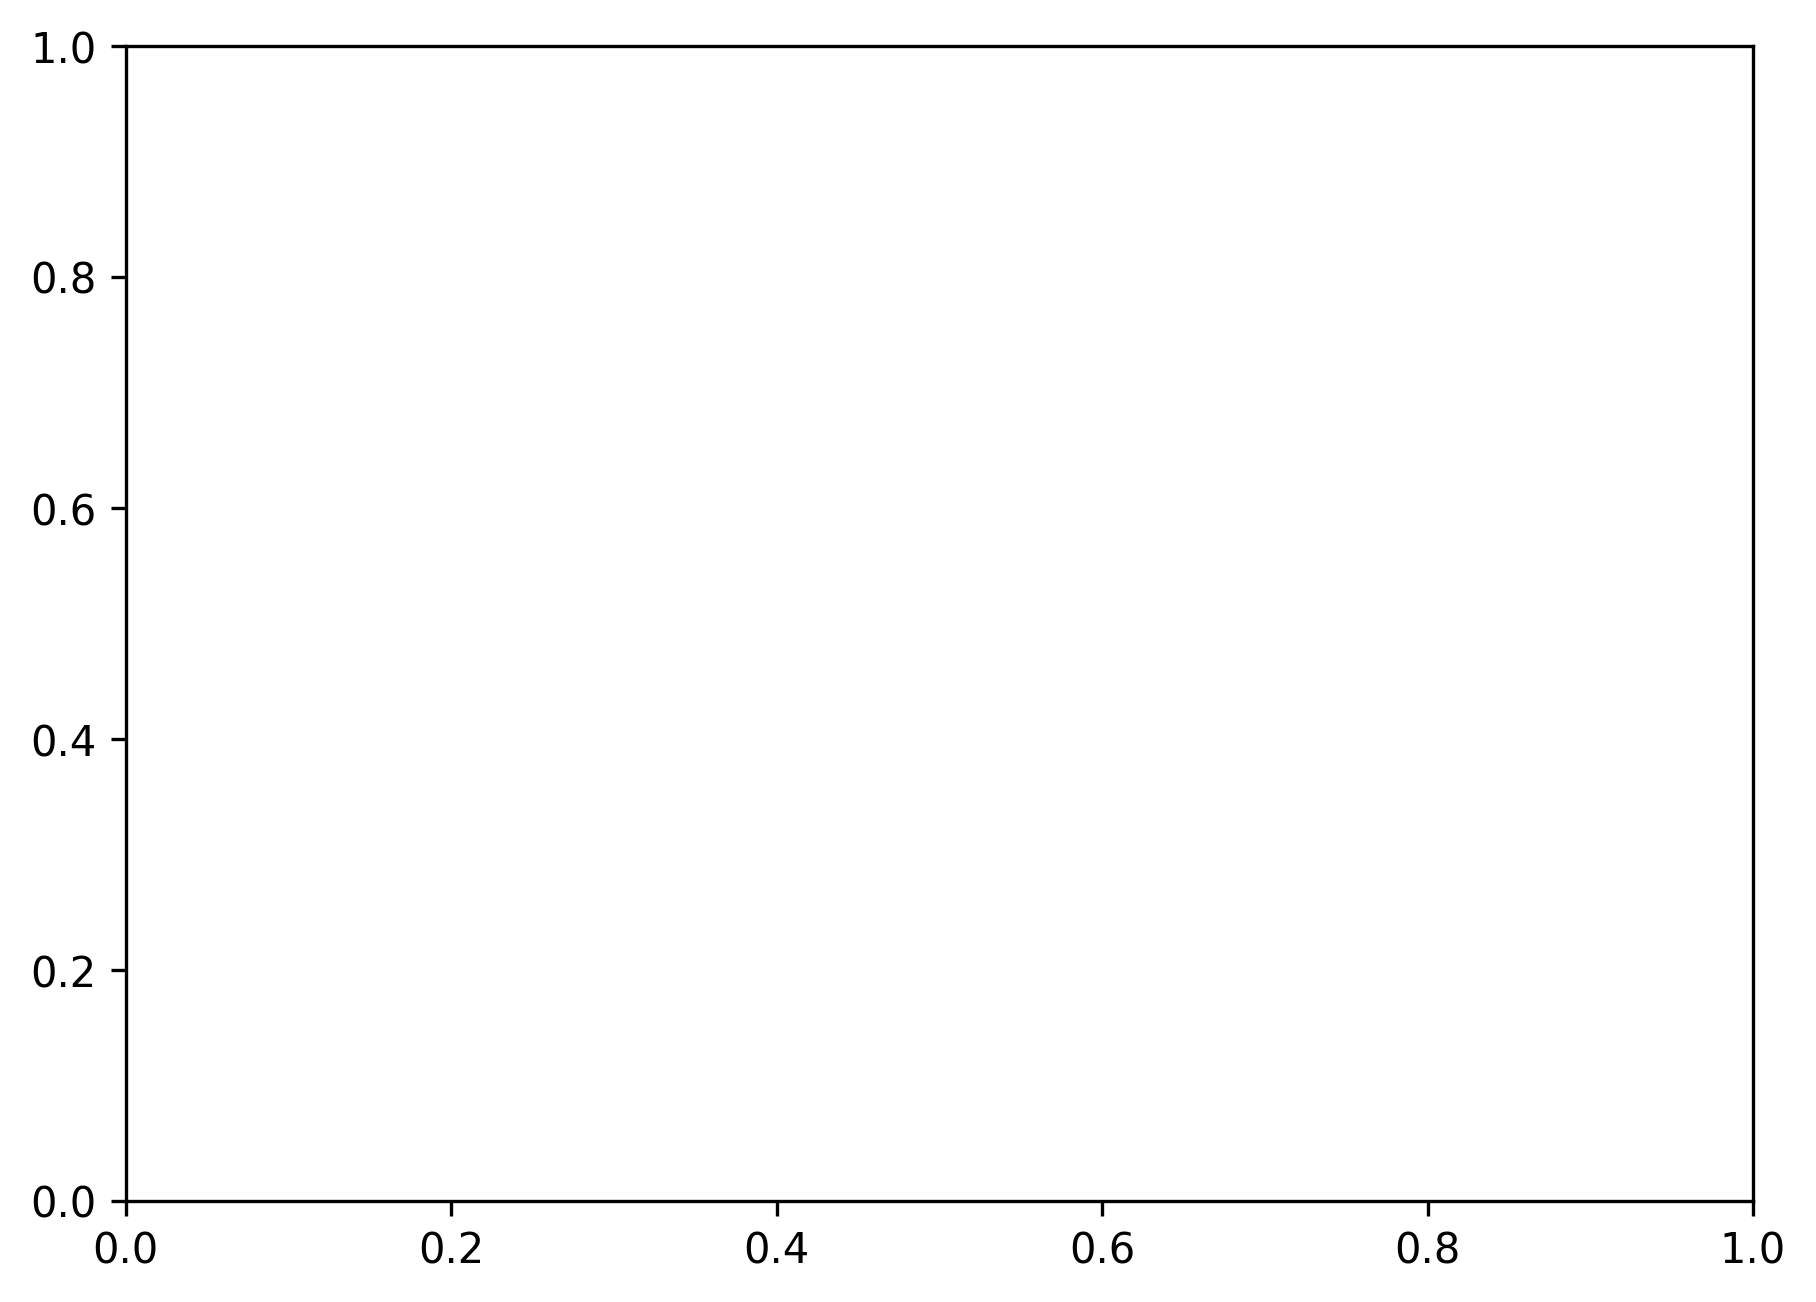

In [18]:
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 100
e_ads = 0.25
e_des = np.inf
e_int_des = 0
e_diff_params = [np.inf, 0.1, 0.15, 0.2, 0.25, 0.3]

# Paleta de colores
custom_palette = (
    list(plt.get_cmap("tab10").colors) +
    list(plt.get_cmap("Set3").colors) +
    list(plt.get_cmap("Paired").colors) +
    list(plt.get_cmap("tab20b").colors)
)
color_cycle = cycle(custom_palette)

# Carpeta de salida
output_dir = "figuras_kmc"
os.makedirs(output_dir, exist_ok=True)

# Crear figura
fig, ax = plt.subplots(figsize=(7, 5), dpi=300)
lines = []

for e_diff in e_diff_params:
    lattice = SquareLattice(size=lattice_size)
    processes = {
        "adsorption": {"e_ads": e_ads},
        "desorption": {"e_des": e_des, "e_int_des": e_int_des},
        "diffusion": {"e_diff": e_diff}
    }
    kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
    occupancy = kmc.run_simulation()
    print(kmc.events_count)
    y = list(occupancy.values())

    color = next(color_cycle)
    label = r"Sin difusión" if e_diff == np.inf else f"$E_{{0}}^{{diff}}$ = {e_diff}"
    line, = ax.plot(time_array, y, linestyle='-', color=color, label=label)
    lines.append((line, e_diff))

# Resaltar e_diff = inf
for line, e_diff in lines:
    if e_diff == np.inf:
        line.set_linewidth(2)
        line.set_color('red')
        line.set_alpha(1.0)
        line.set_zorder(10)
    else:
        line.set_linewidth(1.5)
        line.set_alpha(0.6)

# Etiquetas
ax.set_xlabel("Tiempo (min)")
ax.set_ylabel("$Q_t$ (%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.grid(True)
plt.tight_layout()

# Guardar figura
output_path = os.path.join(output_dir, f"Simulacion_e_diff_e_ads_{e_ads}_e_des_{e_des}.pdf")
fig.savefig(output_path, bbox_inches='tight')
plt.close(fig)

print(f"Figura guardada en: {output_path}")